In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bootstrapped.bootstrap import bootstrap
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import bootstrapped.permutation as pm
from datetime import timedelta
import scipy.stats as stats
from scipy.stats import sem
import pandas as pd
import numpy as np
import swifter
import copy
import sys
import re
import os.path
import warnings
warnings.filterwarnings('ignore')

# Local Modules
sys.path.insert(0, os.path.abspath('/data/manoel/platform_bans/'))
from helpers.vars import interventions, interventions_helper, int_ls, int_c, grace_period, exclude_dates
from helpers.regression_helpers import regression_helper, get_coms, get_content_helper
from helpers.plot import set_size, match_plot_ccdf, plot_intervention
from helpers.match_helpers import get_matched_dataframes

In [4]:
# Latex Configuration
from matplotlib.patches import FancyArrowPatch
import matplotlib.font_manager as font_manager
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.dates
import os

def handle_10(x):
    if "[10^{-3}]" not in x:
        return x
    x = x.replace("[10^{-3}]", "")
    
    pos = x.find("^")
    x = x + r'\times 10^{-3}'
    return x

fontpath = os.path.expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'serif',
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
    'text.usetex': False
    }

mpl.rcParams.update(params)
DATA_PATH = "/Users/horta/PycharmProjects/platform_migrations/"

## Loads data

In [5]:
df_before_after_in = pd.read_csv("./data/reproducibility_data/user_matched_incels.csv")
df_before_after_td = pd.read_csv("./data/reproducibility_data/user_matched_td.csv")
df_before_after_in_f = pd.read_csv("./data/reproducibility_data/user_matched_incels_f.csv")
df_before_after_td_f = pd.read_csv("./data/reproducibility_data/user_matched_td_f.csv")
df_gb_in = pd.read_csv("./data/reproducibility_data/user_incels.csv")
df_gb_td = pd.read_csv("./data/reproducibility_data/user_td.csv")

## Figure 4

TD
mean all before 37.31698375207641    (36.198144206810625, 38.4802027097176)
mean matched before 127.27996763379956    (120.2398711131661, 134.8849439371171)
mean all after 73.0491995131542    (70.01178104422182, 76.26239116187622)
mean matched after 107.16674372904868    (100.3748034909259, 114.41951219512195)
Reddit all vs. matched
KstestResult(statistic=0.36780833091473303, pvalue=0.0)
Fringe all vs. matched
KstestResult(statistic=0.12794375945371034, pvalue=1.2594346706493508e-97)
Reddit all vs. Fringe all
KstestResult(statistic=0.09654880760764994, pvalue=4.454133062063693e-184)
Reddit matched vs. Fringe matched
KstestResult(statistic=0.14946248988556235, pvalue=1.1509206308046445e-84)
----
Incels
mean all before 19.779632905793896    (18.24987560813799, 21.450579113224233)
mean matched before 319.9038461538462    (264.7017482517483, 381.8293706293706)
mean all after 180.60066079295154    (155.09756607929518, 209.2849669603524)
mean matched after 532.0034965034965    (402.378846

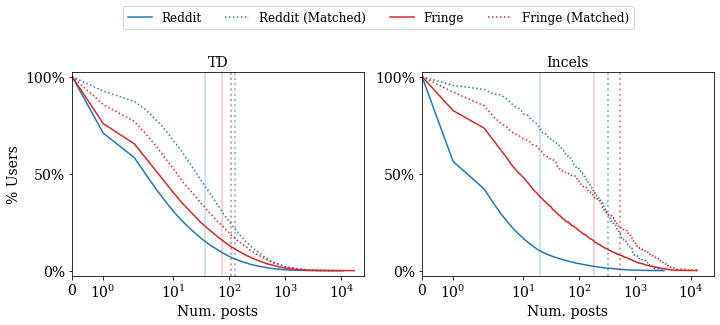

In [19]:
# User-comment CCDF
np.random.seed(437868)

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5), gridspec_kw={"hspace":0.1}, sharex=True, sharey=False)
print("TD")
match_plot_ccdf(df_gb_td, df_before_after_td, axs[0], 
           colors=["tab:blue", "tab:red"])
print("----")

print("Incels")
match_plot_ccdf(df_gb_in, df_before_after_in, axs[1], 
           colors=["tab:blue", "tab:red"])


axs[0].legend(loc="upper center", bbox_to_anchor=(1.05, 1.35), ncol=4)

axs[0].set_title("TD")
axs[1].set_title("Incels")

axs[0].set_ylabel("% Users")
axs[0].set_xlabel("Num. posts")
axs[1].set_xlabel("Num. posts")

for ax in axs:
    ax.set_xscale("symlog")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.))
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlim([0, 2.5*10**4])
    ax.set_yticks([0, 0.5, 1])

set_size(fig, (10, 4.5))
fig.savefig(DATA_PATH + "images/matched_summary_comments.pdf", bbox_inches="tight")

# Figure 5

Mean TD: -0.8088661797031957 Mean IN: -0.5364582631502566
Low TD: -0.866315244900729 Low IN: -0.9659651539973526
Up TD: -0.7514171145056625 Low IN: -0.1069513723031606
Mean TD: 1.0826274218215906 Mean IN: 1.9456787845060612
Low TD: 0.9881851769538815 Low IN: 1.0242198559247497
Up TD: 1.1770696666892997 Low IN: 2.8671377130873728
Mean TD: -0.7221268422974342 Mean IN: -0.7859833598877478
Low TD: -0.8164707119882091 Low IN: -1.5741673918139476
Up TD: -0.6277829726066593 Low IN: 0.0022006720384520895
Mean TD: -1.5422311037463126 Mean IN: -1.3250048771489955
Low TD: -1.6479774899102575 Low IN: -2.02571162592932
Up TD: -1.4364847175823676 Low IN: -0.624298128368671
Mean TD: -2.0444359284856746 Mean IN: -1.9495151007520266
Low TD: -2.1618767485105814 Low IN: -2.6892764099314177
Up TD: -1.926995108460768 Low IN: -1.2097537915726355


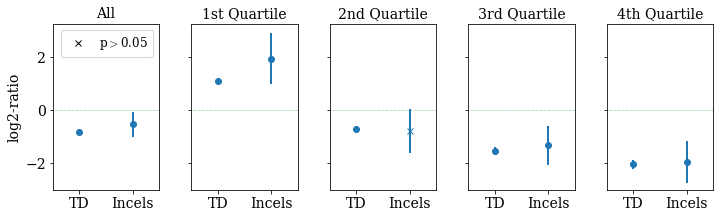

In [24]:
# log-ratio before vs after

fig, axs = plt.subplots(1, 5, figsize=(10, 3), sharey=True, sharex=True, gridspec_kw={"wspace":0.3})
flierprops = dict(marker='o', markeredgecolor='gray', markersize=3,  alpha=0.4, zorder=0)

# Calculates log-ratios in user activity
df_before_after_in["diff"] = np.log2((df_before_after_in["num_posts_y"])/df_before_after_in["num_posts_x"])
df_before_after_td["diff"] = np.log2((df_before_after_td["num_posts_y"])/df_before_after_td["num_posts_x"])

login = df_before_after_in["diff"].values
logtd = df_before_after_td["diff"].values

ax = axs[0]
ax.axhline(0, zorder=1, lw=0.5, color="green", ls=":")
ax.scatter([-0.5, 0.5], [np.mean(logtd), np.mean(login)], color="tab:blue", marker="o", lw=1, zorder=1)
ax.plot([-0.5, -0.5], [np.mean(logtd)-1.96*sem(logtd), np.mean(logtd)+1.96*sem(logtd)], lw=2, color="tab:blue")
ax.plot([0.5, 0.5], [np.mean(login)-1.96*sem(login), np.mean(login)+1.96*sem(login)], lw=2, color="tab:blue")
ax.set_title("All")
ax.set_xlim([-1, 1])
ax.set_ylim([-3, 3.25])
ax.set_xticks([-0.5, 0.5])
ax.set_xticklabels(["TD", "Incels"])
titles = ["1st", "2nd", "3rd", "4th"]
# prints means!
print("Mean TD:", np.mean(logtd), "Mean IN:", np.mean(login))
print("Low TD:", np.mean(logtd) - 1.96 * sem(logtd), "Low IN:", np.mean(login) - 1.96 * sem(login))
print("Up TD:", np.mean(logtd) + 1.96 * sem(logtd), "Low IN:", np.mean(login) + 1.96 * sem(login))

for ptile in [1,2,3,4]:
    ax = axs[ptile]
    login = df_before_after_in.loc[df_before_after_in.ptile == ptile, "diff"].values
    logtd = df_before_after_td.loc[df_before_after_td.ptile == ptile, "diff"].values
    
    # prints means!
    print("Mean TD:", np.mean(logtd), "Mean IN:", np.mean(login))
    print("Low TD:", np.mean(logtd) - 1.96 * sem(logtd), "Low IN:", np.mean(login) - 1.96 * sem(login))
    print("Up TD:", np.mean(logtd) + 1.96 * sem(logtd), "Low IN:", np.mean(login) + 1.96 * sem(login))
    
    # plots "stuff"
    condx = np.mean(logtd) - 1.96 * sem(logtd) < 0 and np.mean(logtd) + 1.96 * sem(logtd) > 0
    ax.scatter([-0.5], [np.mean(logtd)], color="tab:blue", marker="x" if condx else "o" , lw=1, zorder=1)
    condx = np.mean(login) - 1.96 * sem(login) < 0 and np.mean(login) + 1.96 * sem(login) > 0
    ax.scatter([0.5], [np.mean(login)], color="tab:blue", marker="x" if condx else "o" , lw=1, zorder=1)
    ax.plot([-0.5, -0.5], [np.mean(logtd)-1.96*sem(logtd), np.mean(logtd)+1.96*sem(logtd)], lw=2, color="tab:blue")
    ax.plot([0.5, 0.5], [np.mean(login)-1.96*sem(login), np.mean(login)+1.96*sem(login)], lw=2, color="tab:blue")
    ax.axhline(0, zorder=1, lw=0.5, color="green", ls=":")
    
    # y-ticks/lim and x-ticks are hardcoded
    ax.set_xticks([-0.5, 0.5]) 
    ax.set_xticklabels(["TD", "Incels"])
    ax.set_ylim([-3, 3.25])
    ax.set_xlim([-1, 1])
    ax.set_title("{} Quartile".format(titles[ptile-1]))
        
# set only one y-label
axs[0].set_ylabel('log2-ratio')

# Plots the legend
legend_elements = [Line2D([0], [0], color='black', marker='x', lw=0)]
axs[0].legend(legend_elements, ["p$>$0.05"])

set_size(fig, (10, 3))
fig.savefig(DATA_PATH +  "images/matched_comp.pdf", bbox_inches="tight")

## Figure 7

fixation_dict in 220
fixation_dict in 220
fixation_dict td 3710
fixation_dict td 3710
user-level td fixation_dict -0.14700083473048606
user-level in fixation_dict -0.143457426363873
SEVERE_TOXICITY80p in 129
SEVERE_TOXICITY80p in 129
SEVERE_TOXICITY80p td 277
SEVERE_TOXICITY80p td 277
user-level td SEVERE_TOXICITY80p 0.4068728379792733
user-level in SEVERE_TOXICITY80p 0.13914871654172617
NegativeEmotion in 193
NegativeEmotion in 193
NegativeEmotion td 2666
NegativeEmotion td 2666
user-level td NegativeEmotion 0.10910396887247799
user-level in NegativeEmotion -0.019226779256715648
CoreHostility in 238
CoreHostility in 238
CoreHostility td 5846
CoreHostility td 5846
user-level td CoreHostility 0.11169122511773642
user-level in CoreHostility 0.13978876345108462
We in 182
We in 182
We td 4614
We td 4614
user-level td We 0.25634921562019375
user-level in We -0.022673674062653176
They in 198
They in 198
They td 5167
They td 5167
user-level td They 0.1131932173487163
user-level in They -0.002

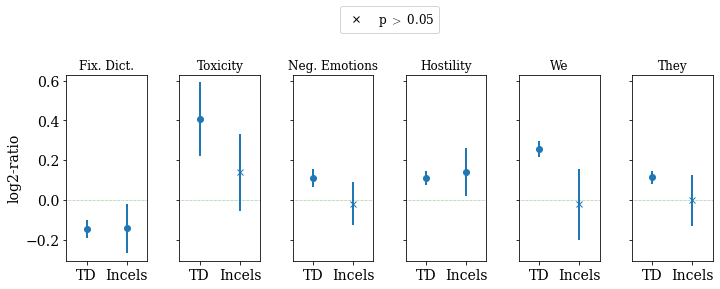

In [23]:
for x in ["SEVERE_TOXICITY80p", "NegativeEmotion", "CoreHostility", "We", 
          "They", "length", "fixation_dict"]:
    if x == "fixation_dict":
        x = "fixation_dict_td"
    df_before_after_td["diff_" + x.replace("_td", "")] = np.log2(df_before_after_td[x + "_y"].values/
                                                                  df_before_after_td[x + "_x"].values)
    df_before_after_td_f["diff_" + x.replace("_td", "")] = np.log2(df_before_after_td_f[x + "_y"].values/
                                                                    df_before_after_td_f[x + "_x"].values)
    if x == "fixation_dict_td":
        x = "fixation_dict_incels"
    df_before_after_in["diff_" + x.replace("_incels", "")] = np.log2(df_before_after_in[x + "_y"].values/
                                                                     df_before_after_in[x + "_x"].values)
    df_before_after_in_f["diff_" + x.replace("_incels", "")] = np.log2(df_before_after_in_f[x + "_y"].values/
                                                                       df_before_after_in_f[x + "_x"].values)

ylabels = [
    "Fix. Dict.",
    "Toxicity", 
    "Neg. Emotions", 
    "Hostility",
    "We",
    "They"]

fig, axs = plt.subplots(1, 6, figsize=(10, 4), sharey=True, sharex=True, gridspec_kw={"wspace":0.4})
flierprops = dict(marker='o', markeredgecolor='gray', markersize=3,  alpha=0.4, zorder=0)
from scipy.stats import sem

for idx, vx in enumerate( ["fixation_dict", "SEVERE_TOXICITY80p", "NegativeEmotion", "CoreHostility", 
                           "We", "They"]):
        
    idy = 0

    login = df_before_after_in_f  if idx <=2 and idx != 0 else df_before_after_in
    login = login
    addv = "_incels" if  vx == "fixation_dict" else ""
    login = login[(login[vx + addv +  "_x"] > 0) & (login[vx + addv +  "_y"] > 0)]
    login = login.loc[:, "diff_" + vx]
    login = login.replace([np.inf, -np.inf], np.nan)
    print(vx, "in", len(login))
    login = login[~login.isna()]
    print(vx, "in", len(login))

    logtd = df_before_after_td_f if idx <=2 and idx != 0 else df_before_after_td
    logtd = logtd
    addv = "_td" if  vx == "fixation_dict" else ""
    logtd = logtd[(logtd[vx + addv +  "_x"] > 0) & (logtd[vx + addv +  "_y"] > 0)]
    logtd = logtd.loc[:, "diff_" + vx]
    logtd = logtd.replace([np.inf, -np.inf], np.nan)
    print(vx, "td", len(logtd))

    logtd = logtd[~logtd.isna()]
    print(vx, "td", len(logtd))

    ax = axs[idx]
    ax.axhline(0, zorder=1, lw=0.5, color="green", ls=":")
    condx = np.mean(logtd) - 1.96 * sem(logtd) < 0 and np.mean(logtd) + 1.96 * sem(logtd) > 0
    ax.scatter([idy], [np.mean(logtd)], color="tab:blue", 
               marker="x" if condx else "o", lw=1, zorder=1)
    ax.plot([idy, idy], [np.mean(logtd)-1.96*sem(logtd), np.mean(logtd)+1.96*sem(logtd)], 
            lw=2, color="tab:blue", zorder=3)
    ax.set_title(ylabels[idx], size=12)#
    
    idy = 1


    condx = np.mean(login) - 1.96 * sem(login) < 0 and np.mean(login) + 1.96 * sem(login) > 0
    ax.scatter([idy], [np.mean(login)],color="tab:blue", 
               marker="x" if condx else "o", lw=1, zorder=1)
    ax.plot([idy, idy], [np.mean(login)-1.96*sem(login), np.mean(login)+1.96*sem(login)], 
            lw=2, color="tab:blue")
    print("user-level", "td", vx,  np.mean(logtd))
    print("user-level", "in", vx,  np.mean(login))

            
for ax in axs.flatten():
    bottom, top = ax.get_ylim()
    v = max(abs(bottom), abs(top))
#     ax.set_ylim([-1.05 * v, 1.05 * v])
    ax.set_xticklabels(["TD", "Incels"], rotation=0, ha="center")
    ax.set_xticks([0, 1])
    ax.set_xlim([-0.5, 1.5])

legend_elements = [Line2D([0], [0], color='black', marker='x', lw=0)]
axs[0].set_ylabel('log2-ratio')

axs[2].legend(legend_elements, [ "p $>$ 0.05"], 
                  bbox_to_anchor=(1.2, 1.4), ncol=3, loc="upper center")

set_size(fig, (10, 4))

fig.savefig(DATA_PATH + "images/matched_comp_cont.pdf", bbox_inches="tight")

---